In [1]:
import time
import datetime
import itertools
import pickle

import numpy as np
import numpy.random as rn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras import layers
from keras.layers import Input, Embedding, LSTM, GRU, Bidirectional, Conv1D, Dense
from keras.layers import Dropout, BatchNormalization, Flatten, Reshape, Lambda, dot, add
from keras.regularizers import l2
from keras.optimizers import Adadelta
from keras.activations import selu
from keras.callbacks import Callback,ModelCheckpoint
np.random.seed(1234)

## Loading word word_2_vec embeddings from file, Dimensional length - 300
with open('word_2_vec.pkl', 'rb') as input:
    word_2_vec = pickle.load(input)

Using TensorFlow backend.


In [2]:
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
FRACTION_OF_DATA=0.01
SENTENCE_LEN = 20
EMBEDDING_LEN = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.05

In [3]:
df = pd.read_csv('filtered.csv',encoding = "ISO-8859-1")
questions_cols = ['q1', 'q2']
df=df.sample(frac=FRACTION_OF_DATA)  ## Samples 1 percent of data from the original dataframe without replacement

In [4]:
## Creates a dictionary of (index,word) pairs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['q1'].tolist()+df['q2'].tolist())

## Replaces every word in the question with the index of the word in the dictionary.
df['q1'] = tokenizer.texts_to_sequences(df['q1'])
df['q2'] = tokenizer.texts_to_sequences(df['q2'])

## Dictionary of (index,word) pairs
vocabulary = tokenizer.word_index

## Initialing embeddings matrix with random values
embeddings = 1 * np.random.randn(len(vocabulary) + 1, EMBEDDING_LEN)  
embeddings[0] = 0      ## Embedding vector for unrecognized words

## Filling up the embedding matrix with actual embedding values
for word, index in vocabulary.items():
    if word in word_2_vec:
        embeddings[index] = word_2_vec[word]
    else:
        print(word)

In [5]:
# Split to train validation
X = df[questions_cols]
Y = df['is_duplicate']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=TEST_SPLIT)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALIDATION_SPLIT)

# Split to dicts
X_train      = {'left': X_train.q1,      'right': X_train.q2}
X_validation = {'left': X_validation.q1, 'right': X_validation.q2}
X_test       = {'left': X_test.q1,       'right': X_test.q2}

# Convert labels to their numpy representations
Y_train      = Y_train.values
Y_validation = Y_validation.values
Y_test       = Y_test.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side],  maxlen=SENTENCE_LEN)

In [6]:
# Model variables
DROPOUT = 0.2
NODES = 50
GRADIENT_CLIP_NORM = 1.25
BATCH_SIZE = 64
EPOCHS = 2

## exponent_neg_manhattan_distance
def distance_ENM(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
## Does not work yet
def distance_Cosine(left, right):
    left = K.l2_normalize(left, axis=-1)
    right = K.l2_normalize(right, axis=-1)
    return K.mean(1 - K.sum((left * right), axis=-1),axis=-1)

In [ ]:
## https://github.com/bradleypallen/keras-quora-question-pairs/blob/master/quora-question-pairs-training-attention.ipynb
def Attention_Model():
    question1 = Input(shape=(SENTENCE_LEN,))
    question2 = Input(shape=(SENTENCE_LEN,))

    q1 = Embedding(len(embeddings), 
                     EMBEDDING_LEN, 
                     weights=[embeddings], 
                     input_length=SENTENCE_LEN, 
                     trainable=False)(question1)
    q1 = Bidirectional(LSTM(EMBEDDING_LEN, return_sequences=True), merge_mode="sum")(q1)

    q2 = Embedding(len(embeddings), 
                     EMBEDDING_LEN, 
                     weights=[embeddings], 
                     input_length=SENTENCE_LEN, 
                     trainable=False)(question2)
    q2 = Bidirectional(LSTM(EMBEDDING_LEN, return_sequences=True), merge_mode="sum")(q2)

    attention = dot([q1,q2], [1,1])
    attention = Flatten()(attention)
    attention = Dense((SENTENCE_LEN*EMBEDDING_LEN))(attention)
    attention = Reshape((SENTENCE_LEN, EMBEDDING_LEN))(attention)

    merged = add([q1,attention])
    merged = Flatten()(merged)
    merged = Dense(NODES, activation='relu')(merged)
    merged = Dropout(DROPOUT)(merged)
    merged = BatchNormalization()(merged)
    merged = Dense(NODES, activation='relu')(merged)
    merged = Dropout(DROPOUT)(merged)
    merged = BatchNormalization()(merged)

    is_duplicate = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=[question1,question2], outputs=is_duplicate)
    return model
#model=Attention_Model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Starting training at ", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([X_train['left'], X_train['right']],
                    Y_train,
                    epochs=EPOCHS,
                    validation_data=([X_validation['left'], X_validation['right']], Y_validation),
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))
#model.summary()

Starting training at  2018-10-29 20:22:05.869168
Train on 2875 samples, validate on 320 samples
Epoch 1/3


In [11]:
## https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
## https://medium.com/mlreview/implementing-malstm-on-kaggles-quora-question-pairs-competition-8b31b0b16a07
def LSTM_Model():
    # The visible layer
    left_input = Input(shape=(SENTENCE_LEN,), dtype='int32')
    right_input = Input(shape=(SENTENCE_LEN,), dtype='int32')

    embedding_layer = Embedding(len(embeddings), EMBEDDING_LEN, weights=[embeddings], input_length=SENTENCE_LEN, trainable=False)

    # Embedded version of the inputs
    encoded_left = embedding_layer(left_input)
    encoded_right = embedding_layer(right_input)

    # Since this is a siamese network, both sides share the same LSTM
    shared_lstm = LSTM(NODES)

    left_output = shared_lstm(encoded_left)
    right_output = shared_lstm(encoded_right)

    # Calculates the distance as defined by the MaLSTM model
    distance = Lambda(function=lambda x: distance_ENM(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

    # Pack it all up into a model
    model = Model([left_input, right_input], [distance])
    return model

model=LSTM_Model()
model.compile(loss='mean_squared_error', optimizer=Adadelta(clipnorm=GRADIENT_CLIP_NORM), metrics=['accuracy'])

model = model.fit([X_train['left'], X_train['right']], Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

Train on 2875 samples, validate on 320 samples
Epoch 1/2
2875/2875 [==============================] - 10s 4ms/step - loss: 0.2466 - acc: 0.6369 - val_loss: 0.2345 - val_acc: 0.6594
Epoch 2/2
2875/2875 [==============================] - 3s 881us/step - loss: 0.2317 - acc: 0.6515 - val_loss: 0.2274 - val_acc: 0.6594


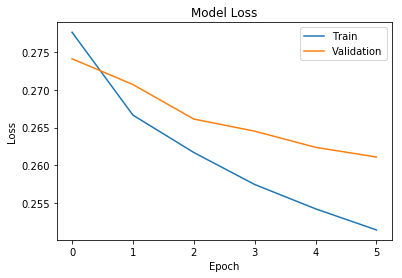

In [19]:
# Plot loss
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
## Constructing word index and embedding matrix manually
vocabulary = {}
inverse_vocabulary = ['<unk>']
# Iterate over the questions only of both training and test datasets
for dataset in [train, test]:
    for index, row in dataset.iterrows():
        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in (row[question]).split(' '):
                # Check for unwanted words
                #if word in stops and word not in word2vec.vocab:
                #    continue
                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])
            # Replace questions with lists of word indices
            dataset.set_value(index, question, q2n)

embeddings = 1 * np.random.randn(len(vocabulary) + 1, 300)  
embeddings[0] = 0

for word, index in vocabulary.items():
    if word in word_2_vec:
        embeddings[index] = word_2_vec[word]
    else:
        print(word)

In [ ]:
import os
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'

## Save to file
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


## Draw model architecture
SVG(model_to_dot(model).create(prog='dot', format='svg'))
model.summary()

# load json and create model
from keras.models import model_from_json

with open('model.json', 'r') as json_file:
    model = model_from_json(json_file.read())

# load weights into new model
model.load_weights("model.h5")

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model = model.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=EPOCHS,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))
score = model.evaluate(X, Y, verbose=0)

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")